#### POLYGON - POLYGON INTERSECTION
##### Author: Simone Poncioni, MSB
##### Date: 03.10.2022

<div>
<img src="Intersection_01.jpg" width="1000"/>
</div>

### Check and correct minimal thickness

#### Hypotheses:
- Internal array must be always internal (no intersection)
- No self intersection of the polygons
- Both arrays indexes increase counter clockwise (ccw) --> already checked previously

#### Procedure:
1. Get [x_e, y_e] and [x_i, y_i] coordinates arrays (slice-wise)
2. Get normals of [(x_n+1 - x_n), (y_n+1 - y_n)]:

`norm = math.hypot(dx, dy) * 1/min_thickness`

3. Check number of elements, otherwise resample evenly spaced points of len([ext])
4. Check array indexing (x_1_ext =!= x_1_int)
5. Check min thickness --> store it in a boolean array of [True, ..., False], where True if:
   
`bool_min_thickness = [i<min_thickness for i in dist]`      with     `dist = np.sqrt(dist_x**2 + dist_y**2)`

6. Where True, correct internal position of the point by moving the end point of the segment by `[arr[:, 0] - dy, arr[:, 1] + dx]` (where dx, dy already include min thickness requested (see pt. 2)) 
7. Update [x_i, y_i] coordinates array without impacting external coordinates


#### TODOS:
- In implementation make sure ccw check comes before checking distances (otherwise arrays will become more and more distant)
- Check for inter-polygon intersection and how to handle it

##### Imports and configurations

In [ ]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('white')

# rcParams
f = 1
plt.rcParams['figure.figsize'] = [10 * f, 10 * f]
plt.rcParams['font.size'] = 15

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

##### Functions and helpers

[Angles between 2 n-dim vectors](https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python)

In [ ]:
def unit_vector(vector):
    """
    Returns the unit vector in numpy form

    Args:
        vector (numpy.ndarray): 2D numpy array, e.g. ([5, 5])

    Returns:
        list: comprehension list of 2D unit vectors (calculated "row-by-row"), e.g. [0.7, 0.7]
    """
    return [vector[0] / np.linalg.norm(vector, axis=-1), vector[1] / np.linalg.norm(vector, axis=-1)]


def ccw_angle(array1, array2):
    """
    Returns the angle between two 2D arrays in the range [0, 2*pi)
    Args:
        array1 (numpy.ndarray): array of shape (2,) containing [x, y] coords
        array2 (numpy.ndarray): array of shape (2,) containing [x, y] coords

    Returns:
        numpy.ndarray: array of shape (1,) containing angles between array1 and array2
    """
    # Get the angle between the two arrays
    angle = np.arctan2(array2[:, 1], array2[:, 0]) - np.arctan2(array1[:, 1], array1[:, 0])
    # If the angle is negative, add 2*pi
    angle = np.where(angle < 0, angle + 2*np.pi, angle)
    return angle


def convertRadiansToDegrees(radians):
    """Converts radians to degrees"""
    return radians * 180 / np.pi


def reset_numpy_index(arr, idx=1):
    """
    Reset the index of a numpy array to a given index
    Args:
        arr (numpy.ndarray): _description_
        idx (int): index to reset to. Defaults to 1.

    Returns:
        numpy.ndarray: numpy array with index reset to idx
    """
    return np.r_[arr[idx:, :], arr[:idx, :]]


def is_angle_bigger_bool(alpha_int, alpha_ext):
    """
    Returns True if alpha_int is bigger than alpha_ext, False otherwise
    If alpha_int is bigger than alpha_ext, then the internal angle is bigger than the external angle
    If np.nan, then return False and print a warning
    Else, return False

    Args:
        alpha_int (numpy.ndarray): array of shape (1,) containing internal angles
        alpha_ext (numpy.ndarray): array of shape (1,) containing external angles

    Raises:
        ValueError: print a warning if alpha_int or alpha_ext is np.nan (0-degree angle)
        RuntimeWarning: error if comparison is not possible

    Returns:
        numpy.ndarray: array containing True if alpha_int is bigger than alpha_ext, False otherwise
    """    
    if alpha_int >= alpha_ext:
        bool_angle = True
    elif alpha_int < alpha_ext:
        bool_angle = False
    elif alpha_ext == np.nan() or alpha_int == np.nan():
        bool_angle = False
        raise ValueError('value is nan, 0-angle vector is undefined')
    else:
        bool_angle = False
        raise RuntimeWarning()
    return bool_angle

https://stackoverflow.com/questions/25649788/optimal-way-to-append-to-numpy-array
https://realpython.com/numpy-array-programming/
https://stackoverflow.com/questions/16613546/using-arctan-arctan2-to-plot-a-from-0-to-2%CF%80
https://math.stackexchange.com/questions/878785/how-to-find-an-angle-in-range0-360-between-2-vectors
https://stackoverflow.com/questions/64409191/angle-between-two-vectors-in-the-interval-0-360

In [ ]:
def is_internal_inside_external(ext_c, int_c):
    '''
    # pseudo-code:
    # Compute unit vectors between Pe0-Pe1 and Pe1-Pe2
    # v1_e_u = unit_vector(ext[i+1]-ext[i])
    # v2_e_u = unit_vector(ext[i+2]-ext[i+1])

    # Compute unit vector between Pe1-Pe2 and Pe1-Pi_1  #TODO: careful, always CCW angle!
    # v1_e_u = unit_vector(ext[i+1] - ext[i])  #TODO: already computed, just for reference
    # v2_i_u = unit_vector(int[i] - ext[i+1])

    # Compute angles between vectors
    # alpha_e = angle_between(v1_e_u, v2_e_u)
    # alpha_i = angle_between(v1_e_u, v2_i_u)


    # TESTS
    n_points = 50
    angles = np.linspace(0 * np.pi, 2 * np.pi, n_points)
    v1 = np.full((n_points, 2), [1, 0])
    x = np.cos(angles)
    y = np.sin(angles)
    v2 = np.c_[x, y]
    angles = ccw_angle(v1, v2)
    '''
    p_e_0 = ext_c
    p_i_0 = int_c
    p_e_1 = reset_numpy_index(p_e_0, idx=1)
    p_e_2 = reset_numpy_index(p_e_0, idx=2)
    p_i_1 = reset_numpy_index(p_i_0, idx=2) #! changed from idx=1

    alpha_ext = ccw_angle(p_e_2 - p_e_1, p_e_0 - p_e_1)
    alpha_int = ccw_angle(p_e_2 - p_e_1, p_i_1 - p_e_1)
    boolean_angle = [is_angle_bigger_bool(alpha_int, alpha_ext) for alpha_int, alpha_ext in zip(alpha_int, alpha_ext)]
    return boolean_angle


def check_intersection(ext, int, min_thickness=1):
    """
    Checks thickness of ext, int arrays and returns a list of booleans
    of form [True, ..., False] where True means the thickness if below tolerance.

    Arguments:
        ext {ndarray} -- array of [x, y] points of external polygon
        int {ndarray} -- array of [x, y] points of internal polygon
        min_thickness {float} -- minimum thickness tolerance between ext/int

    Returns:
        bool_min_thickness {list}  -- list indicating where the thickness is below tolerance
    """    
    dist_x = ext[:, 0] - int[:, 0]
    dist_y = ext[:, 1] - int[:, 1]
    dist = np.sqrt(dist_x**2 + dist_y**2)

    bool_min_thickness = [i<min_thickness for i in dist]
    return bool_min_thickness


def correct_internal_point(arr, dx, dy):
    """
    Corrects [x, y] position of points of internal array

    Args:
        arr (ndarray): array of internal perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness

    Returns:
        ndarray: new position of internal points in array 'arr'
    """
    return np.array([arr[:, 0] - dy, arr[:, 1] + dx]).transpose()


def correct_intersection(ext_arr, int_arr, dx, dy, bool_arr):
    """
    Takes external and internal arrays and applies nodal displacement to the elements where bool_min_thickness == True

    Args:
        ext_arr (ndarray): array of [x, y] external points composing the perimeter
        int_arr (ndarray): array of [x, y] internal points composing the perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness
        bool_min_thickness (list): list indicating where the thickness is below tolerance

    Returns:
        ndarray: new array of internal polygon
    """
    print(f'ext_arr: {np.shape(ext_arr)}')
    print(f'int_arr: {np.shape(int_arr)}')
    print(f'dx: {np.shape(dx)}')
    print(f'dy: {np.shape(dy)}')
    print(f'bool_arr: {np.shape(bool_arr)}')


    bool_arr = np.c_[bool_arr, bool_arr]
    int_corr = correct_internal_point(ext_arr, dx, dy)
    np.copyto(dst=int_arr, src=int_corr, where=bool_arr)
    return int_arr


def draw_arrow(ax, arr_start, arr_end, text, color):
    """
    Helper that draws normals with arrow and vector annotation

    Args:
        ax (AxesSubplot): ax where to add the arrow
        arr_start (tuple): tuple of arrow starting point
        arr_end (tuple): tuple of arrow ending point
        text (str): string of text to add as annotation
        color (str): color of arrow + annotation
    """
    dx = arr_end[0] - arr_start[0]
    dy = arr_end[1] - arr_start[1]
    ax.arrow(arr_start[0], arr_start[1], dx, dy, head_width=0.01, head_length=0.01, length_includes_head=True, color=color)
    ax.annotate(text, xy=(arr_end[0], arr_end[1]), xytext=(arr_end[0]-25, arr_end[1]-35), color=color, 
             xycoords = 'data', textcoords="offset points",
             size=16, va="center")
    return None


def get_normals(xs, ys, ax1, ax2, thickness=1):
    """
    Get normal arrays point-wise for array [xs, ys]
    # TODO: needs optimization (array operations)
    
    Args:
        xs (ndarray): x-component of contour array
        ys (ndarray): y-component of contour array
        ax1 (AxesSubplot): ax subplot 1
        ax2 (AxesSubplot): ax subplot 2
        thickness (int, optional): Minimum thickness of int-ext interface. Defaults to 1.

    Returns:
        dx_arr (ndarray): array of dx component of the normals
        dy_arr (ndarray): array of dy component of the normals
        dx_med (ndarray): array of resultant normal between (x_n and x_n+1)
        dy_med (ndarray): array of resultant normal between (y_n and y_n+1)
    """
    dx_arr = []
    dy_arr = []  
    for idx in range(len(xs)-1):
        x0, y0, xa, ya = xs[idx], ys[idx], xs[idx+1], ys[idx+1]
        dx, dy = xa-x0, ya-y0
        norm = math.hypot(dx, dy) * 1/thickness
        dx /= norm
        dy /= norm

        dx_arr = np.append(dx_arr, dx)
        dy_arr = np.append(dy_arr, dy)

        ax1.plot(((x0+xa)/2, (x0+xa)/2-dy), ((y0+ya)/2, (y0+ya)/2+dx), color='tab:grey')    # plot the normals
        draw_arrow(ax2, (x0, y0), (x0-dy, y0+dx), text=' ', color='tab:grey')
        draw_arrow(ax2, (xa, ya), (xa-dy, ya+dx), text=' ', color='tab:grey')

    dx_arr = np.insert(dx_arr, 0, dx_arr[-1]) #! added this
    dy_arr = np.insert(dy_arr, 0, dy_arr[-1]) #! added this

    dx_arr = np.append(dx_arr, dx_arr[0]) #! added this
    dy_arr = np.append(dy_arr, dy_arr[0]) #! added this
    
    dx_med = []
    for dx in range(len(dx_arr)-1):
        dx_med_s = (dx_arr[dx] + dx_arr[dx+1]) * 0.5
        dx_med = np.append(dx_med, dx_med_s)

    dy_med = []
    for dy in range(len(dy_arr)-1):
        dy_med_s = (dy_arr[dy] + dy_arr[dy+1]) * 0.5
        dy_med = np.append(dy_med, dy_med_s)

    for idx in range(len(xs)-1):
        x0, y0, xa, ya = xs[idx], ys[idx], xs[idx+1], ys[idx+1]
        draw_arrow(ax2, (x0, y0), (x0-dy_med[idx], y0+dx_med[idx]), text=f'$\\vec{{n}}_{{res}}${idx}', color='tab:green')

    return dx_arr, dy_arr, dx_med, dy_med


def get_circle(radius, center, n_points=15):
    """
    Get a circle to create synthetic test data

    Args:
        radius (float): radius of the circle
        center (list): center of the circle
        n_points (int): number of points that compose the circle. Defaults to 15.

    Returns:
        x_s (ndarray): array containing x position of circle
        y_s (ndarray): array containing y position of circle
    """
    angles = np.linspace(0 * np.pi, 2 * np.pi, n_points)
    xs = radius * np.cos(angles) + center[0]
    ys = radius * np.sin(angles) + center[1]
    return xs, ys


def show_circles(center, n_points=15, min_thickness=1):
    """
    Create circles, get normals, plot

    Args:
        center (list): center of the circle
        n_points (int): number of points that compose the circle. Defaults to 15.
        min_thickness (int, optional): Minimum thickness of int-ext interface. Defaults to 1.

    Returns:
        ext_a (ndarray): 2D array of [x, y] points
        int_a (ndarray): 2D array of [x, y] points
        dx_arr (ndarray): array of dx component of the normals
        dy_arr (ndarray): array of dy component of the normals
        dx_med (ndarray): array of resultant normal between (x_n and x_n+1)
        dy_med (ndarray): array of resultant normal between (y_n and y_n+1)
        fig (matplotlib.figure.Figure): figure
        ax1 (AxesSubplot): ax subplot
        ax2 (AxesSubplot): ax subplot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.plot(center[0], center[1], color = 'red', marker = 'o', label='center')
    ax1.annotate(f'O {center}', xy=(center[0] + 0.1, center[1] - 0.1), xycoords='data')
    x_ext, y_ext = get_circle(radius=1, center=center, n_points=n_points)
    x_int, y_int = get_circle(radius=1.01, center=center, n_points=n_points)

    dx, dy, dx_med, dy_med = get_normals(x_ext, y_ext, ax1, ax2, thickness=min_thickness)

    ext_a = np.c_[x_ext, y_ext]
    int_a = np.c_[x_int, y_int]
    
    ax1.plot(x_ext, y_ext, label='external contour')
    ax2.plot(x_ext, y_ext)
    ax1.plot(x_int, y_int, label='initial internal contour')
    ax2.plot(x_int, y_int)
    return ext_a, int_a, dx, dy, dx_med, dy_med, fig, ax1, ax2


##### Main

In [ ]:
# PARAMS
c = [0, 0]
MIN_THICKNESS = 100e-3
N_POINTS = 15

# MAIN
ext_s, int_s, dx, dy, dx_med, dy_med, fig, ax1, ax2 = show_circles(center=c, n_points=N_POINTS, min_thickness=MIN_THICKNESS)

boolean_angle = is_internal_inside_external(ext_s, int_s)
print(f'Is internal contour outside external contour?\n{boolean_angle}')

dx_med[-1] = dx_med[0]  # guarantees continuity / closes the loop
dy_med[-1] = dy_med[0]  # guarantees continuity / closes the loop

print(f'Median normal vectors of external contour:\n{np.around(np.c_[dx_med, dy_med], 3)}')

new_int = correct_intersection(ext_arr=ext_s,
                               int_arr=int_s,
                               dx=dx_med,
                               dy=dy_med,
                               bool_arr=boolean_angle
                               )

bool_min_thickness_s = check_intersection(ext=ext_s, int=new_int, min_thickness=MIN_THICKNESS)
new_int = correct_intersection(ext_arr=ext_s,
                               int_arr=new_int,
                               dx=dx_med,
                               dy=dy_med,
                               bool_arr=bool_min_thickness_s
                               )

ax1.plot(new_int[:, 0], new_int[:, 1], linestyle=':', label='corrected internal contour')
ax2.plot(new_int[:, 0], new_int[:, 1], linestyle=':')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax2.set_xlim(0.8, 1.1)
ax2.set_ylim(-0.2, 0.2)
fig.suptitle('Correction of internal position ($\\vec{n}$-based)', weight='bold', fontsize=20)
fig.legend(loc=1)
fig.tight_layout()


ax1.plot((ext_s[:, 0], ext_s[:, 0]-dy_med), (ext_s[:, 1], ext_s[:,1]+dx_med), color='tab:blue')
# fig.savefig('Correction_internal_position.svg')
fig.savefig('Correction_external_position.eps', format='eps')
print('')

- - -
#### Test above code on real slice

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as shpg
from scipy.interpolate import splev, splprep
from scipy import spatial

def offset_surface(ext_line, offset):
    '''
    Create artificial internal surface based on an offset
    Don't implement in main script it's just for testing
    '''
    # Create a Polygon from the 2d array
    poly = shpg.Polygon(ext_line)

    # Create offset in inward direction
    noffpoly = poly.buffer(offset)  # offset

    # Turn polygon points into numpy arrays for plotting
    afpolypts = np.array(poly.exterior)
    noffafpolypts = np.array(noffpoly.exterior)
    return noffafpolypts


def resample_polygon(xy: np.ndarray, n_points: int = 100) -> np.ndarray:
    """
    Cumulative Euclidean distance between successive polygon points.

    Args:
        xy (np.ndarray): 2D-array of [x, y] contour
        n_points (int, optional): Number of points to resample contour. Usually len(ext contour). Defaults to 100.

    Returns:
        np.ndarray: Resampled contour [x, y]
    """
    d = np.cumsum(np.r_[0, np.sqrt((np.diff(xy, axis=0) ** 2).sum(axis=1))])

    # get linearly spaced points along the cumulative Euclidean distance
    d_sampled = np.linspace(0, d.max(), n_points)

    # interpolate x and y coordinates
    xy_interp = np.c_[
        np.interp(d_sampled, d, xy[:, 0]),
        np.interp(d_sampled, d, xy[:, 1]),
    ]
    return xy_interp

#### Create artificial data

In [ ]:
ext_path = r'ext_surf_slice_minus1.npy'
ext_spline = np.load(ext_path)
int_spline = offset_surface(ext_spline, offset=1e-1)

n = 80
int_spline = resample_polygon(int_spline, n_points=n)
ext_spline = resample_polygon(ext_spline, n_points=n)


np.save('int_spline_minus1.npy', int_spline)

plt.figure(figsize=(10, 10))
plt.plot(ext_spline[:, 0], ext_spline[:, 1])
plt.plot(int_spline[:, 0], int_spline[:, 1])
print('')

In [ ]:
def nearest_point(arr, pt):
    """
    Find nearest point between an array and a point (e.g. the first point of ext contour)

    Args:
        arr (ndarray): 2D array of contour
        pt (list): (x, y) coordinates of point

    Returns:
        loc (numpy.ndarray): location of nearest point in the array
        dist (float): distance between point and nearest point in array
        idx (numpy.int64): index of point in array
    """
    dist, idx = spatial.KDTree(arr).query(pt)
    loc = arr[spatial.KDTree(arr).query(pt)[1]]
    return loc, dist, idx


def add_noise_to_contour(int, variability=0.1):
    """
    Add noise to contour

    Args:
        int (ndarray): 2D array of contour
        n_points (int): number of points to resample contour
        variability (float, optional): variability of noise. Defaults to 0.1.

    Returns:
        int (ndarray): 2D array of contour with noise
    """
    noise = np.random.normal(0, variability, size=int.shape)
    x = int[:, 0] + noise[:, 0]
    y = int[:, 1] + noise[:, 0]
    return int


def show_centres(min_thickness, x_ext, y_ext, x_int, y_int):
    """
    Create contours, get normals, plot

    Args:
        min_thickness (int): Minimum thickness of int-ext interface.
        x_ext (ndarray): array of [x] component of external array
        y_ext (ndarray): array of [y] component of external array
        x_int (ndarray): array of [x] component of internal array
        y_int (ndarray): array of [y] component of internal array

    Returns:
        ext_a (ndarray): 2D array of [x, y] points
        int_a (ndarray): 2D array of [x, y] points
        dx_arr (ndarray): array of dx component of the normals
        dy_arr (ndarray): array of dy component of the normals
        dx_med (ndarray): array of resultant normal between (x_n and x_n+1)
        dy_med (ndarray): array of resultant normal between (y_n and y_n+1)
        fig (matplotlib.figure.Figure): figure
        ax1 (AxesSubplot): ax subplot
        ax2 (AxesSubplot): ax subplot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    dx, dy, dx_med, dy_med = get_normals(x_ext, y_ext, ax1, ax2, thickness=min_thickness)

    ext_a = np.c_[x_ext, y_ext]
    int_a = np.c_[x_int, y_int]
    
    ax1.plot(x_ext, y_ext, label='external contour')
    ax2.plot(x_ext, y_ext)
    ax1.plot(x_int, y_int, label='initial internal contour')
    ax2.plot(x_int, y_int)

    for i, txt in enumerate(range(len(x_ext))):
        ax2.annotate(txt, (x_ext[i], y_ext[i]))
        ax2.annotate(txt, (x_int[i], y_int[i]))

    return ext_a, int_a, dx, dy, dx_med, dy_med, fig, ax1, ax2

In [ ]:
### TESTING
MIN_THICKNESS = 100e-3

ext_path = r'ext_surf_slice_minus1.npy'
int_path = r'int_spline_minus1.npy'
ext_spline = np.load(ext_path)
int_spline = np.load(int_path)
n = 10
int_spline = resample_polygon(int_spline, n_points=n)
ext_spline = resample_polygon(ext_spline, n_points=n)

# TODO: invert order in function rather than in real data (ONLY for testing)
ext_spline[:, 0] = np.flip(ext_spline[:, 0])
ext_spline[:, 1] = np.flip(ext_spline[:, 1])
int_spline[:, 0] = np.flip(int_spline[:, 0])
int_spline[:, 1] = np.flip(int_spline[:, 1])


################

loc_int, dist_int, idx_int = nearest_point(int_spline, [ext_spline[0, 0], ext_spline[0, 1]])
int_spline = np.roll(int_spline, -idx_int, axis=0)

ext_s, int_s, dx, dy, dx_med, dy_med, fig, ax1, ax2 = show_centres(min_thickness=MIN_THICKNESS,
                                                                   x_ext=ext_spline[:, 0],
                                                                   y_ext=ext_spline[:, 1],
                                                                   x_int=int_spline[:, 0],
                                                                   y_int=int_spline[:, 1])

boolean_angle = is_internal_inside_external(ext_s, int_s)
print(f'Is internal contour outside external contour?\n{boolean_angle}')

dx_med[-1] = dx_med[0]  # guarantees continuity / closes the loop
dy_med[-1] = dy_med[0]  # guarantees continuity / closes the loop

new_int = correct_intersection(ext_arr=ext_s,
                               int_arr=int_s,
                               dx=dx_med,
                               dy=dy_med,
                               bool_arr=boolean_angle
                               )

bool_min_thickness_s = check_intersection(ext=ext_s, int=new_int, min_thickness=MIN_THICKNESS)
new_int = correct_intersection(ext_arr=ext_s,
                               int_arr=new_int,
                               dx=dx_med,
                               dy=dy_med,
                               bool_arr=bool_min_thickness_s
                               )

ax1.scatter(ext_spline[0,0], ext_spline[0, 1], marker='x', s=300)
ax1.scatter(int_spline[0,0], int_spline[0, 1], marker='x', s=300)
ax1.scatter(loc_int[0], loc_int[1], marker='x', s=300)

ax1.plot(new_int[:, 0], new_int[:, 1], linestyle=':', label='corrected internal contour')
ax2.plot(new_int[:, 0], new_int[:, 1], linestyle=':')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax2.set_xlim(16.5, 16.8)
ax2.set_ylim(14.5, 15.5)
fig.suptitle('Correction of internal position ($\\vec{n}$-based)', weight='bold', fontsize=20)
fig.legend(loc=1)
fig.tight_layout()


ax1.plot((ext_s[:, 0], ext_s[:, 0]-dy_med), (ext_s[:, 1], ext_s[:,1]+dx_med), color='tab:blue')
# fig.savefig('Correction_external_position_mwe.svg')
# fig.savefig('Correction_external_position_mwe.png', dpi=300)
print('Done')

### TESTING SCIPY SPATIAL DISTANCE MATRIX

[gfg guide](https://www.geeksforgeeks.org/scipy-spatial-distance-matrix/)

[scipy spatial docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html)


[Euclidean vs Chebyshev distance](https://math.stackexchange.com/questions/2436479/chebyshev-vs-euclidean-distance)

Syntax: scipy.spatial.distance_matrix(x, y, p=2)
 
Parameters:
    x : (M, K) Matrix of M vectors, each of dimension K. 
    y : (N, K) Matrix of N vectors, each of dimension K. 
    p : float, 1 <= p <= infinity, defines which Minkowski p-norm to use.

Returns: (M, N) ndarray
/ matrix containing the distance from every vector in x to every vector in y.

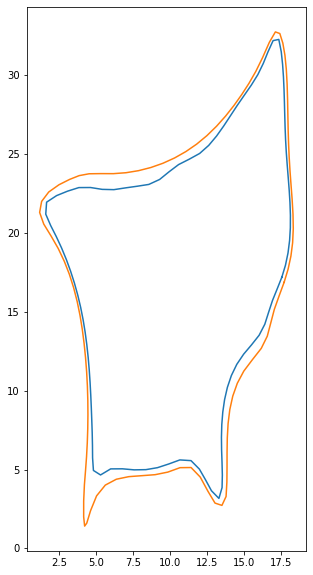

In [2]:
import matplotlib.pyplot as plt
import numpy as np

ext_array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_ext_2.npy')
int_array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_int_2.npy')

plt.figure(figsize=(5, 10))
plt.plot(int_array[:, 0], int_array[:, 1])
plt.plot(ext_array[:, 0], ext_array[:, 1])


(array([ 5, 23, 24, 48, 55]), array([ 5, 24, 25, 50, 58]))



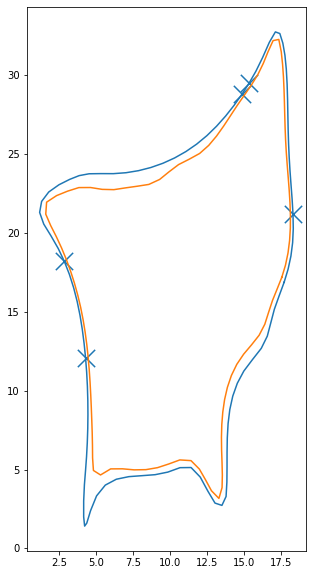

In [7]:
import numpy as np
from scipy.spatial import distance_matrix


# compute the distance matrix
dist_mat = distance_matrix(ext_array, int_array, p=3) # p=2 means euclidean distance

tol = 180e-3
indices = np.where(dist_mat < tol)
print(indices)

# plot indices
plt.figure(figsize=(5, 10))
plt.plot(ext_array[:, 0], ext_array[:, 1])
plt.plot(int_array[:, 0], int_array[:, 1])
plt.scatter(ext_array[indices[0], 0], ext_array[indices[0], 1], marker='x', s=300)
print('')

In [28]:
import scipy.spatial as spatial

def nearest_pairs_arrs(arr1, arr2):
    """
    Find nearest point between two arrays and create a an array containing nearest-pairs indices
    
    Args:
        arr1 (np.ndarray): array of contour 1
        arr2 (np.ndarray): array of contour 2
        
    Returns:
        _type_: _description_
    """
    
    closest_idx = np.empty((len(arr1), 2), dtype=int)
    base_idx = np.empty((len(arr1), 2), dtype=int)
    for i, idx in enumerate(arr1):
        _, closest_idx_s = spatial.KDTree(arr2).query(idx)
        closest_idx[i] = closest_idx_s
        base_idx[i] = i
    return closest_idx, base_idx

closest_idx, base_idx = nearest_pairs_arrs(ext_array, int_array)
pairs = np.c_[base_idx[:, 0], closest_idx[:, 0]]
print(pairs)

[[ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 4  4]
 [ 5  5]
 [ 6  6]
 [ 7  7]
 [ 8  9]
 [ 9 10]
 [10 11]
 [11 12]
 [12 13]
 [13 14]
 [14 15]
 [15 17]
 [16 18]
 [17 19]
 [18 19]
 [19 19]
 [20 20]
 [21 22]
 [22 23]
 [23 24]
 [24 25]
 [25 26]
 [26 27]
 [27 28]
 [28 30]
 [29 31]
 [30 32]
 [31 33]
 [32 34]
 [33 35]
 [34 37]
 [35 38]
 [36 39]
 [37 40]
 [38 41]
 [39 42]
 [40 43]
 [41 44]
 [42 44]
 [43 45]
 [44 46]
 [45 47]
 [46 48]
 [47 49]
 [48 50]
 [49 51]
 [50 52]
 [51 53]
 [52 55]
 [53 56]
 [54 57]
 [55 58]
 [56 59]
 [57 60]
 [58 61]
 [59 63]
 [60 64]
 [61 65]
 [62 66]
 [63 67]
 [64 67]
 [65 68]
 [66 68]
 [67 68]
 [68 68]
 [69 68]
 [70 68]
 [71 68]
 [72 69]
 [73 71]
 [74 72]
 [75 73]
 [76 74]
 [77 75]
 [78 76]
 [79 78]
 [80 79]
 [81 80]
 [82 80]
 [83 80]
 [84 81]
 [85 83]
 [86 84]
 [87 85]
 [88 86]
 [89 87]
 [90 88]
 [91 90]
 [92 91]
 [93 92]
 [94 93]
 [95 94]
 [96 95]
 [97 96]
 [98 98]
 [99  0]]


In [39]:
from scipy.spatial import KDTree

tree = KDTree(ext_array)
neighbor_dists, neighbor_indices = tree.query(int_array, k=1)

print(neighbor_indices)

[ 0  1  2  3  4  5  6  7  8  8  9 10 11 12 13 14 15 15 16 17 20 21 21 22
 23 24 25 26 27 27 28 29 30 31 32 33 33 34 35 36 37 38 39 41 42 43 44 45
 46 47 48 49 50 51 51 52 53 54 55 56 57 58 59 59 60 61 62 63 71 72 73 73
 74 75 76 77 78 79 79 80 81 84 84 85 86 87 88 89 90 90 91 92 93 94 95 96
 97 98 98  0]
